In [419]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

#mean squared error, mean absolute error, and coefficient of determination
import lcpfn.lcpfn as lcpfn

path_test = '/mnt/c/Users/prath/PycharmProjects/rp/LCDB_localised/test_curves.pkl'
df_test = pd.read_pickle(path_test)

# model_name = '/mnt/c/Users/prath/PycharmProjects/rp/model_lcdb.pt'
model_name = None
if model_name is None:
    model = lcpfn.LCPFN()
else:
    model = lcpfn.LCPFN(model_name=model_name)

In [421]:
def get_validation_curve(rng:np.random):
    """Retrieve the validation curve for a given model and dataset."""
    #slect a random row from the dataframe
    row = rng.choice(len(df_test)-1)
    row = df_test.iloc[row]
    #get the openml id
    openlid = row['openmlid']
    learner = row['learner']
    anchors = row['anchors']
    means = row['means']
    std = row['std']
    return anchors, means, std, openlid, learner


def get_closest_index(lst, target):
    return min(range(len(lst)), key=lambda i: abs(lst[i] - target))

def get_common_data(cutoff, extend, anchors, means, ):

    means = np.array(means)
    anchors = np.array(anchors)
    anchors = ((anchors - np.min(anchors)) / (np.max(anchors) - np.min(anchors))) * 100

    cutoff_index = get_closest_index(anchors, cutoff)
    curve = np.array(means[:cutoff_index])
    anchors = anchors.astype(int)

    add_anchor = np.arange(anchors[-1], extend, 10)
    a = np.concatenate((anchors, add_anchor))
    x = torch.from_numpy(a).unsqueeze(1)
    y = torch.from_numpy(curve).float().unsqueeze(1)

    return x, y, anchors, means, cutoff_index

def get_mse(model, anchors, means, cutoff=5, extend=100, plot=False):
    x, y, anchors, means, cutoff_index = get_common_data(cutoff, extend, anchors, means, )

    predictions = model.predict_quantiles(x_train=x[:cutoff_index], y_train=y, x_test=x[cutoff_index:], qs=[0.05, 0.5, 0.95])

    if plot:
        plot_it(anchors, means, predictions, cutoff_index, x)

    predictions = predictions.detach().numpy()
    return np.mean((predictions[:len(anchors) - cutoff_index, 1] - means[cutoff_index:]) ** 2)


def get_mae(model, anchors, means ,cutoff=5, extend=100, plot=False):
    x, y, anchors, means, cutoff_index = get_common_data(cutoff, extend, anchors, means,)

    predictions = model.predict_quantiles(x_train=x[:cutoff_index], y_train=y, x_test=x[cutoff_index:], qs=[0.05, 0.5, 0.95])

    if plot:
        plot_it(anchors, means, predictions, cutoff_index, x)

    predictions = predictions.detach().numpy()
    return np.mean(np.abs(predictions[:len(anchors) - cutoff_index, 1] - means[cutoff_index:]))

def get_cod(model, anchors, means, cutoff=5, extend=100, plot=False):
    x, y, anchors, means, cutoff_index = get_common_data(cutoff, extend, anchors, means,)

    predictions = model.predict_quantiles(x_train=x[:cutoff_index], y_train=y, x_test=x[cutoff_index:], qs=[0.05, 0.5, 0.95])

    if plot:
        plot_it(anchors, means, predictions, cutoff_index, x)

    predictions = predictions.detach().numpy()
    cod = r2_score(means[cutoff_index:], predictions[:len(anchors) - cutoff_index, 1])
    return cod

def plot_it(anchors, means, predictions, cutoff_index, x):
    plt.plot(anchors, means, "*", label="target")
    plt.plot(anchors, means, label="target")
    plt.plot(x[cutoff_index:], predictions[:, 1], "r*", label="Extrapolation by PFN")
    plt.fill_between(
        x[cutoff_index:].flatten(), predictions[:, 0], predictions[:, 2], color="blue", alpha=0.2, label="CI of 90%"
    )
    plt.vlines(x[cutoff_index], 0, 1, linewidth=0.5, color="k", label="cutoff")
    plt.ylim(0, 1)
    plt.legend(loc="lower right")
    plt.show()




389 sklearn.naive_bayes.MultinomialNB


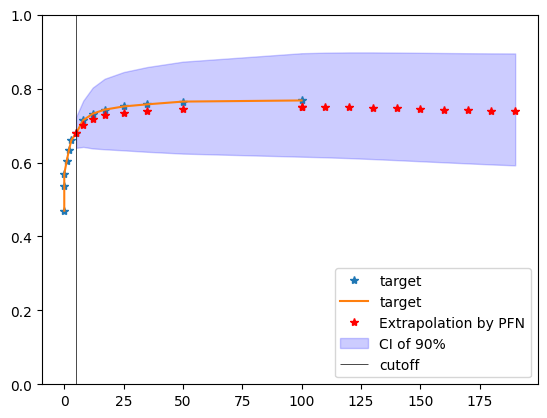

0.00024006093770164802
0.014550602224350007
0.6920185677854145


In [429]:
rng = np.random.default_rng()
anchors, means, std, openlid, learner = get_validation_curve(rng)
print(openlid, learner)

print(get_mse(model, anchors, means, extend=200, plot=True))
print(get_mae(model, anchors, means))
print(get_cod(model, anchors, means))

In [404]:
performance  = []
performance_lable  = []

for i in range(100):
    print(i+1, end='\r')
    anchors, means, std, openlid, learner = get_validation_curve(rng)
    performance.append([get_mse(model, anchors, means), get_mae(model, anchors, means), get_cod(model, anchors, means)])
    performance_lable.append(str(int(openlid)) + '_' + learner)

performance  = np.array(performance )

In [403]:
# Print the results in a clear format
df = pd.DataFrame(performance, columns=['mse', 'mae', 'cod'])
print(df.describe())

              mse         mae           cod
count  100.000000  100.000000  1.000000e+02
mean     0.012085    0.066919 -3.428475e+05
std      0.024718    0.073632  3.415520e+06
min      0.000005    0.002126 -3.415627e+07
25%      0.000438    0.019250 -6.996830e+00
50%      0.001645    0.037075 -1.894095e+00
75%      0.008968    0.087251 -2.747523e-01
max      0.135148    0.314721  9.504035e-01
